In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import random
import cv2 as cv
from keras.utils.np_utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.applications import ResNet50
import tensorflow_addons as tfa

In [3]:
data_csv = pd.read_csv("../input/ocular-disease-recognition-odir5k/full_df.csv")

# Building Model 2 i.e - Using VGG16 with all 8 output classes

## Defining all the functions 

In [4]:
# to create dataset of the images based on disease
dataset_dir = "../input/ocular-disease-recognition-odir5k/preprocessed_images/"
image_size = 224
labels = []
ds = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv.imread(image_path,cv.IMREAD_COLOR)
            image = cv.resize(image,(image_size,image_size))
        except:
            continue
        
        ds.append([np.array(image), np.array(label)])
    random.shuffle(ds)
    return ds

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [6]:
def show_images():
    plt.figure(figsize=(12,7))
    for i in range(10):
        sample = random.choice(range(len(ds)))
        image = ds[sample][0]
        label = ds[sample][1]
        if label == 0:
            label = "Normal"
        elif label == 1:
            label = "Cataract"
        elif label == 2:
            label = "Diabetes"
        elif label == 3:
            label = "Glaucoma"
        elif label == 4:
            label = "Age-related conditions"
        elif label == 5:
            label = "Hypertension related conditions"
        elif label == 6:
            label = "Myopia"
        elif label == 7:
            label = "Other reasons"
        plt.subplot(2,5,i+1)
        plt.imshow(image)
        plt.xlabel(label)
    plt.tight_layout() 
    
   

In [7]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()

In [8]:
# creating a dictionary which stores the disease text string to search, The label it has in data_csv and 
# the label that we are giving for that particular disease
disease_dict = {'cataract': ['C',2], 
                'normal': ['N',1],
                'glaucoma' : ['G', 4],
               'retinopathy':['D',3],
               'age-related': ['A',5],
               'hypertensive' : ['H', 6],
               'myopia' : ['M', 7],
               'other' : ['O', 8]}


# final dictionary to store our file names 
combined_dict = {}

# function to segregate image names based on the fundus disease
def diseased_fundus():
    for disease_name, disease_label in disease_dict.items():
        left_eye_col_name = 'left_' + disease_name 
        right_eye_col_name = 'right_' + disease_name
        # creating a blank column for left and right eye to avoid keyerror
        data_csv[left_eye_col_name] = " "
        data_csv[right_eye_col_name] = " "
        # creating two new columns, one for the left eye and one for the right 
        for index, row in data_csv.iterrows():
            # for rest of the cases 
            if disease_name in data_csv['Left-Diagnostic Keywords'][index]:
                data_csv[left_eye_col_name][index] = disease_label[1]
            else:
                data_csv[left_eye_col_name][index] = 0
            if disease_name in data_csv['Right-Diagnostic Keywords'][index]:
                data_csv[right_eye_col_name][index] = disease_label[1]
            else:
                data_csv[right_eye_col_name][index] = 0
            # seperate case for other retinal diseases (for column where 'O' is 1)
            if disease_name == 'other':
                if ('cataract' or 'normal' or 'glaucoma' or 'retinopathy' or 'age-related' or 'hypertensive' or 'myopia') not in data_csv['Left-Diagnostic Keywords'][index]:
                    data_csv[left_eye_col_name][index] = disease_label[1]
                else:
                    data_csv[left_eye_col_name][index] = 0
                if ('cataract' or 'normal' or 'glaucoma' or 'retinopathy' or 'age-related' or 'hypertensive' or 'myopia') not in data_csv['Right-Diagnostic Keywords'][index]:
                    data_csv[right_eye_col_name][index] = disease_label[1]
                else:
                    data_csv[right_eye_col_name][index] = 0
        
        # fetching/filtering all the image names where disease exists in the left eye and has value assigned through 
        # our function and using the Left-Fundus column to get the image name 
        left_eye_col_name = data_csv.loc[(data_csv[disease_label[0]] == 1) & (data_csv[left_eye_col_name] == disease_label[1])]['Left-Fundus'].values
        
        # doing the same for the right eye
        right_eye_col_name = data_csv.loc[(data_csv[disease_label[0]] == 1) & (data_csv[right_eye_col_name] == disease_label[1])]['Right-Fundus'].values
        # merging both the left and right eye file names which have the disease 
        print(disease_label[1])
        combined = np.concatenate((left_eye_col_name, right_eye_col_name), axis=0)

        combined_dict[disease_name]  = pd.Series(combined)

        

diseased_fundus()

combined_dict

2
1
4
3
5
6
7
8


{'cataract': 0          0_left.jpg
 1         81_left.jpg
 2        103_left.jpg
 3        119_left.jpg
 4        254_left.jpg
             ...      
 589    2243_right.jpg
 590    2246_right.jpg
 591    2247_right.jpg
 592    2248_right.jpg
 593    2282_right.jpg
 Length: 594, dtype: object,
 'normal': 0           1_left.jpg
 1           8_left.jpg
 2          84_left.jpg
 3         191_left.jpg
 4         394_left.jpg
              ...      
 4196    3448_right.jpg
 4197    3450_right.jpg
 4198    3485_right.jpg
 4199    4571_right.jpg
 4200    4637_right.jpg
 Length: 4201, dtype: object,
 'glaucoma': 0         95_left.jpg
 1        153_left.jpg
 2        167_left.jpg
 3        178_left.jpg
 4        247_left.jpg
             ...      
 611    1999_right.jpg
 612    2030_right.jpg
 613    2032_right.jpg
 614    2048_right.jpg
 615    2063_right.jpg
 Length: 616, dtype: object,
 'retinopathy': 0           2_left.jpg
 1           5_left.jpg
 2          11_left.jpg
 3          19_left.j

In [9]:
ds = []
ds = create_dataset(combined_dict['cataract'], 1)
ds = create_dataset(combined_dict['glaucoma'], 3)
ds = create_dataset(combined_dict['normal'], 0)
ds = create_dataset(combined_dict['retinopathy'], 2) # for diabetes
ds = create_dataset(combined_dict['age-related'],4)
ds = create_dataset(combined_dict['hypertensive'],5)
ds = create_dataset(combined_dict['myopia'],6)
ds = create_dataset(combined_dict['other'],7)

100%|██████████| 3115/3115 [00:21<00:00, 144.21it/s]


In [10]:
# validating our dataset
print(len(ds))
# Shape of the new dataset
print(np.shape(ds))

13049
(13049, 2)


## Validating our dataset creation 

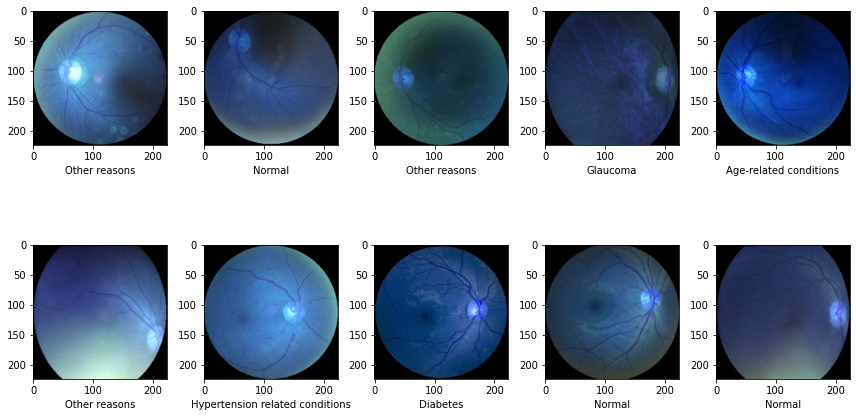

In [11]:
show_images()

## Creating our test and validation set

In [12]:
# Because of the way the labels were created, it's better to categorize them to prevent deceiving the model
X = np.array([i[0] for i in ds]).reshape(-1,image_size,image_size,3)
y = to_categorical([i[1] for i in ds])
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)
X_val,X_test,y_val,y_test = train_test_split(X_val, y_val, test_size=0.5)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(10439, 224, 224, 3)
(1305, 224, 224, 3)
(1305, 224, 224, 3)
(10439, 8)
(1305, 8)
(1305, 8)


## Building our VGG16 Model with all the 8 classes

In [13]:
# Setting up our trained model for our new data set
vgg_2 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape= (224,224,3)
)
vgg_2.trainable = False

x_2 = Flatten()(vgg_2.output)
dense1_2 = Dense(units=128,activation='relu')(x_2)
dense2_2 = Dense(units=128, activation='relu')(dense1_2)
output_2 = Dense(units=8, activation='softmax')(dense2_2)
A_2 = Model(inputs = vgg_2.input, outputs = output_2)
A_2.summary()

2022-04-30 19:29:27.806287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 19:29:27.884536: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 19:29:27.885399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-30 19:29:27.886607: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [14]:
optim_2 = tf.keras.optimizers.Adam(learning_rate = 0.00001)
A_2.compile(optimizer= optim_2, loss= 'categorical_crossentropy', metrics=['accuracy'])
training_2 = A_2.fit(x=X_train, y=y_train, batch_size=128, epochs=20, validation_data=(X_val, y_val))

2022-04-30 19:29:33.552910: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-04-30 19:29:35.268237: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-04-30 19:29:36.504787: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-04-30 19:29:37.911700: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


82/82 [==============================] - 45s 346ms/step - loss: 2.8230 - accuracy: 0.2809 - val_loss: 2.1110 - val_accuracy: 0.3111
Epoch 2/20
82/82 [==============================] - 20s 242ms/step - loss: 1.8172 - accuracy: 0.3652 - val_loss: 1.8203 - val_accuracy: 0.3471
Epoch 3/20
82/82 [==============================] - 20s 241ms/step - loss: 1.5593 - accuracy: 0.4232 - val_loss: 1.6852 - val_accuracy: 0.3778
Epoch 4/20
82/82 [==============================] - 20s 241ms/step - loss: 1.3864 - accuracy: 0.4821 - val_loss: 1.5840 - val_accuracy: 0.4023
Epoch 5/20
82/82 [==============================] - 20s 241ms/step - loss: 1.2541 - accuracy: 0.5270 - val_loss: 1.5057 - val_accuracy: 0.4268
Epoch 6/20
82/82 [==============================] - 20s 241ms/step - loss: 1.1441 - accuracy: 0.5691 - val_loss: 1.4446 - val_accuracy: 0.4529
Epoch 7/20
82/82 [==============================] - 20s 241ms/step - loss: 1.0469 - accuracy: 0.6101 - val_loss: 1.3882 - val_accuracy: 0.4682
Epoch 8/20

In [15]:
accuracy_2 = A_2.evaluate(X_test, y_test)
print(accuracy_2)
y_pred_2 = A_2.predict(X_test)
print(y_pred_2)

41/41 [==============================] - 5s 60ms/step - loss: 1.0082 - accuracy: 0.6513
[1.0082104206085205, 0.6513410210609436]
[[8.2933873e-01 3.6977319e-04 7.2918057e-02 ... 3.0701343e-02
  1.5898263e-02 3.3641588e-02]
 [1.1268474e-02 1.3294701e-04 1.7294480e-01 ... 1.1694179e-02
  1.0752345e-02 6.6437207e-02]
 [5.3780554e-05 2.5016444e-08 1.6819756e-06 ... 8.3576007e-05
  9.9984384e-01 3.5729457e-07]
 ...
 [4.9149945e-02 1.8716453e-02 4.9397987e-01 ... 3.0006026e-03
  1.7914966e-04 3.8049412e-01]
 [1.2038749e-01 1.8250531e-03 2.0534135e-01 ... 4.8168056e-02
  5.0653946e-03 5.4090118e-01]
 [1.4484653e-01 1.7806809e-05 6.1608195e-01 ... 2.8233412e-03
  3.7843620e-07 2.3619886e-01]]


In [16]:
print(f"Validation loss: {accuracy_2[0]}")
print(f"Validation accuracy: {accuracy_2[1]}")

Validation loss: 1.0082104206085205
Validation accuracy: 0.6513410210609436


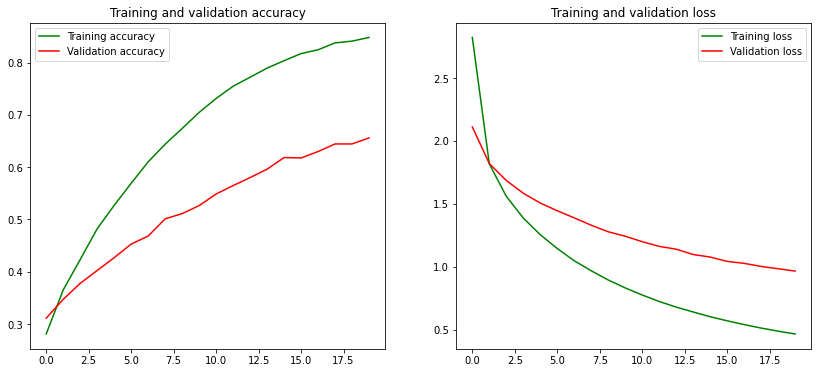

In [17]:
plot_accuracy_and_loss(training_2)

As we can see, the model is not overfitting

In [18]:
y_pred_2 = np.argmax(y_pred_2, axis=1)
y_test_2 = np.argmax(y_test, axis=1)

In [19]:
cm_2 = confusion_matrix(y_test_2, y_pred_2, labels= [0,1,2,3,4,5,6,7])


Normalized confusion matrix
[[0.80661578 0.         0.08651399 0.00763359 0.         0.
  0.         0.09923664]
 [0.03174603 0.79365079 0.12698413 0.01587302 0.         0.
  0.         0.03174603]
 [0.11918605 0.00581395 0.61046512 0.01453488 0.02034884 0.03197674
  0.00290698 0.19476744]
 [0.23214286 0.         0.07142857 0.48214286 0.01785714 0.03571429
  0.03571429 0.125     ]
 [0.03636364 0.         0.14545455 0.01818182 0.45454545 0.
  0.05454545 0.29090909]
 [0.13043478 0.         0.5        0.02173913 0.04347826 0.17391304
  0.         0.13043478]
 [0.0212766  0.         0.0212766  0.0212766  0.         0.
  0.76595745 0.17021277]
 [0.08637874 0.00996678 0.25249169 0.02657807 0.00996678 0.01328904
  0.01328904 0.58803987]]


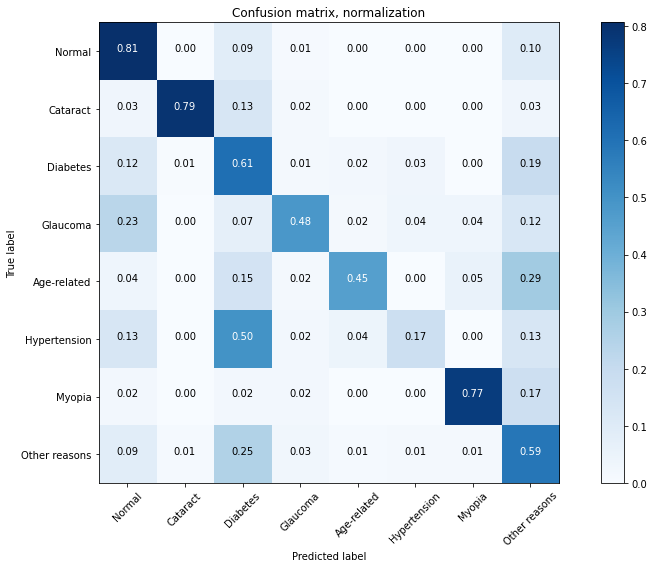

In [20]:
plt.figure(figsize=(12,8))
plot_confusion_matrix(cm_2, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"], 
                      title='Confusion matrix, normalization')


For Normal , Myopia and Cataract, the algorithm did a good job identifying the fundus. Diabetes, Glaucoma, Age related and Other reasons got an average performance. Hypertension had the worst performance. These results makes sense as we had a lot of images fed to the model for Normal, Myopia and Cataract where as Hypertension has the least amount of data (382 images) hence there was less data for the model to learn.  

In [21]:
print(classification_report(y_test_2, y_pred_2, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"]))

accuracy_score(y_test_2, y_pred_2, normalize=True)

               precision    recall  f1-score   support

       Normal       0.78      0.81      0.79       393
     Cataract       0.91      0.79      0.85        63
     Diabetes       0.58      0.61      0.59       344
     Glaucoma       0.57      0.48      0.52        56
  Age-related       0.66      0.45      0.54        55
 Hypertension       0.32      0.17      0.23        46
       Myopia       0.78      0.77      0.77        47
Other reasons       0.55      0.59      0.57       301

     accuracy                           0.65      1305
    macro avg       0.64      0.58      0.61      1305
 weighted avg       0.65      0.65      0.65      1305



0.6513409961685823

We got only a 65% accuracy and can see that the precision and recall was really bad for hypertension. Normal, Cataract, Age-related and Myopia have a good recall and precision as compared to the rest of the diseased fundus which are having an average recall and precision. We will run the model for more epochs and changing the batch size to see if we can get a better accuracy but they seem to be inherited due to the imabalance in our dataset

In [22]:
training_3 = A_2.fit(x=X_train, y=y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val))

2022-04-30 19:37:31.300471: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.
2022-04-30 19:37:33.082462: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1571361792 exceeds 10% of free system memory.


Epoch 1/50
164/164 [==============================] - 26s 132ms/step - loss: 0.4684 - accuracy: 0.8444 - val_loss: 0.9458 - val_accuracy: 0.6736
Epoch 2/50
164/164 [==============================] - 20s 124ms/step - loss: 0.4349 - accuracy: 0.8557 - val_loss: 0.9243 - val_accuracy: 0.6820
Epoch 3/50
164/164 [==============================] - 20s 124ms/step - loss: 0.4041 - accuracy: 0.8648 - val_loss: 0.8995 - val_accuracy: 0.6881
Epoch 4/50
164/164 [==============================] - 20s 124ms/step - loss: 0.3795 - accuracy: 0.8723 - val_loss: 0.8828 - val_accuracy: 0.6973
Epoch 5/50
164/164 [==============================] - 20s 124ms/step - loss: 0.3552 - accuracy: 0.8752 - val_loss: 0.8631 - val_accuracy: 0.6981
Epoch 6/50
164/164 [==============================] - 20s 124ms/step - loss: 0.3368 - accuracy: 0.8784 - val_loss: 0.8599 - val_accuracy: 0.7034
Epoch 7/50
164/164 [==============================] - 20s 124ms/step - loss: 0.3199 - accuracy: 0.8820 - val_loss: 0.8419 - val_ac

In [23]:
accuracy_3 = A_2.evaluate(X_test, y_test)
print(f"Validation loss: {accuracy_3[0]}")
print(f"Validation accuracy: {accuracy_3[1]}")
y_pred_3 = A_2.predict(X_test)
print(y_pred_3)

41/41 [==============================] - 2s 60ms/step - loss: 0.8624 - accuracy: 0.7441
Validation loss: 0.8623720407485962
Validation accuracy: 0.744061291217804
[[9.9270439e-01 1.3803182e-06 3.5367839e-03 ... 8.1381138e-04
  2.2574964e-04 2.4989271e-03]
 [8.0395650e-05 2.7502179e-07 3.3383796e-03 ... 9.9823787e-04
  9.5132104e-04 4.4404017e-03]
 [8.9365676e-07 4.7427676e-11 5.9990555e-08 ... 1.5493754e-06
  9.9999726e-01 5.5718896e-08]
 ...
 [8.4511079e-03 3.1303901e-02 3.2379282e-01 ... 2.7918033e-04
  2.2379927e-05 6.2483871e-01]
 [7.0144162e-03 3.4689117e-05 3.7187204e-01 ... 3.4231953e-03
  3.2140728e-04 6.0975438e-01]
 [3.9697338e-02 6.4093234e-07 9.4575375e-01 ... 6.2363186e-05
  2.6912312e-09 1.4485267e-02]]


Seems like the best accuracy we could achieve 74% 

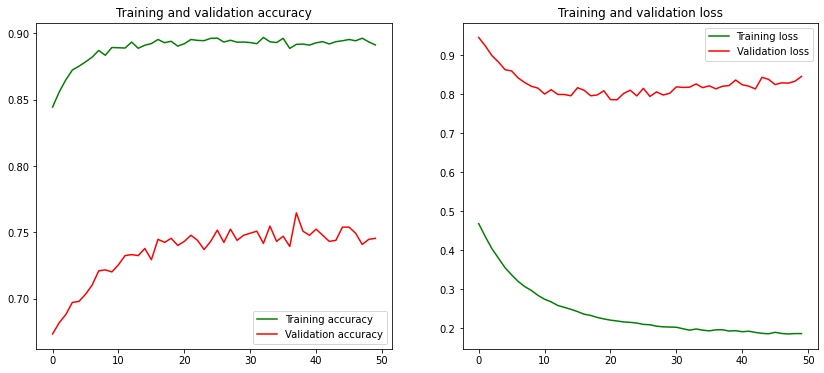

In [24]:
plot_accuracy_and_loss(training_3)

Both our loss and accuracy for both training and validation set seem to be going in the same direction and hence we can conclude that we aren't overfitting

In [25]:
y_pred_3 = np.argmax(y_pred_3, axis=1)
y_test_3 = np.argmax(y_test, axis=1)

Normalized confusion matrix
[[0.91094148 0.         0.02798982 0.00508906 0.00508906 0.
  0.         0.05089059]
 [0.01587302 0.88888889 0.0952381  0.         0.         0.
  0.         0.        ]
 [0.04360465 0.00581395 0.67151163 0.01744186 0.02325581 0.04651163
  0.00581395 0.18604651]
 [0.125      0.         0.08928571 0.55357143 0.03571429 0.03571429
  0.01785714 0.14285714]
 [0.07272727 0.         0.09090909 0.         0.63636364 0.
  0.05454545 0.14545455]
 [0.06521739 0.02173913 0.32608696 0.02173913 0.04347826 0.41304348
  0.         0.10869565]
 [0.04255319 0.         0.0212766  0.         0.         0.
  0.78723404 0.14893617]
 [0.04318937 0.         0.20930233 0.03322259 0.01328904 0.00664452
  0.0166113  0.67774086]]


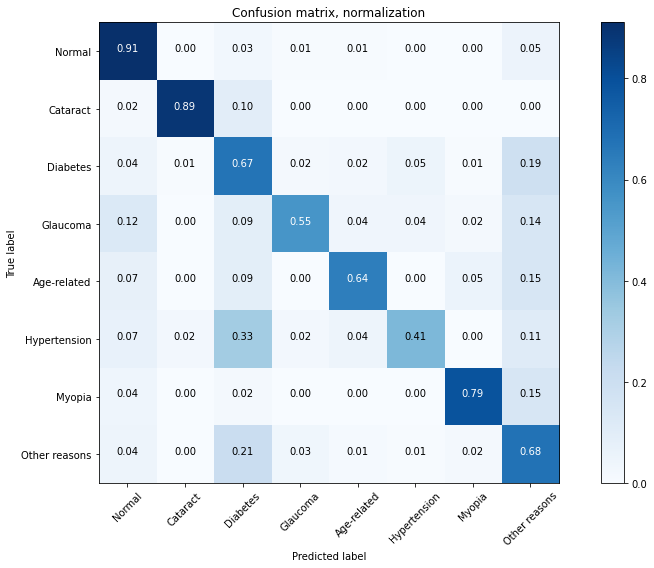

In [26]:
cm_3 = confusion_matrix(y_test_3, y_pred_3, labels= [0,1,2,3,4,5,6,7])

plt.figure(figsize=(12,8))
plot_confusion_matrix(cm_3, classes=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"], 
                      title='Confusion matrix, normalization')


We can see this model is doing alot better than model 2 and that hypertension improved from 0.17 to 0.41

In [27]:
print(classification_report(y_test_3, y_pred_3, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', "Age-related",
                                   "Hypertension", "Myopia", "Other reasons"]))

accuracy_score(y_test_3, y_pred_3, normalize=True)

               precision    recall  f1-score   support

       Normal       0.89      0.91      0.90       393
     Cataract       0.95      0.89      0.92        63
     Diabetes       0.69      0.67      0.68       344
     Glaucoma       0.62      0.55      0.58        56
  Age-related       0.66      0.64      0.65        55
 Hypertension       0.49      0.41      0.45        46
       Myopia       0.77      0.79      0.78        47
Other reasons       0.65      0.68      0.66       301

     accuracy                           0.74      1305
    macro avg       0.71      0.69      0.70      1305
 weighted avg       0.74      0.74      0.74      1305



0.7440613026819923

We can see that both the precision and recall have increased for all the fundus images

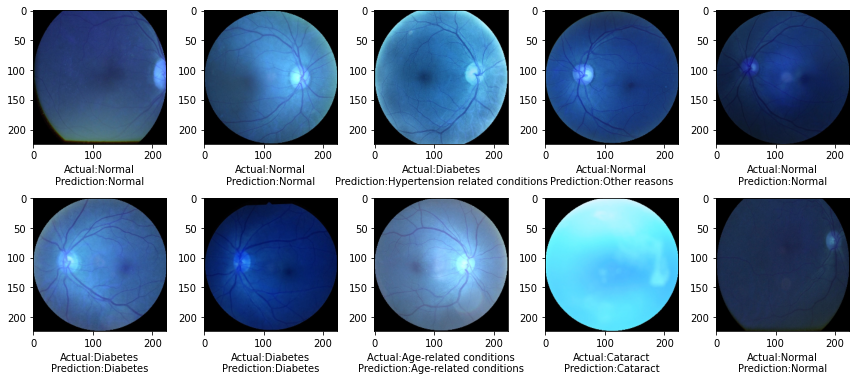

In [28]:
plt.figure(figsize=(12,10))
for i in range(10):
    sample = random.choice(range(len(X_test)))
    image = X_test[sample]
    category = y_test_3[sample]
    pred_category = y_pred_3[sample]
    
    if category == 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Age-related conditions"
    elif category == 5:
        label = "Hypertension related conditions"
    elif category == 6:
        label = "Myopia"
    elif category == 7:
        label = "Other reasons"
    
        
    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1:
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Age-related conditions"
    elif pred_category == 5:
        pred_label = "Hypertension related conditions"
    elif pred_category == 6:
        pred_label = "Myopia"
    elif pred_category == 7:
        pred_label = "Other reasons"
        
    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

We can see that for a random set of images choosen for our test dataset, the model correctly predicted the 8/10 images

## Predicting using our model on completely new image loaded from system

In [29]:
# Loading in new image (the 5K resolution image)

new_image = cv.imread('../input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/2_right.jpg')
new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
new_image = cv.resize(new_image, (224,224))

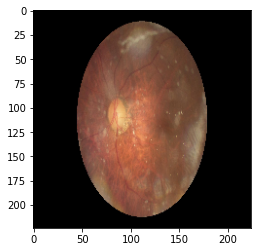

In [30]:
plt.imshow(new_image)

In [31]:
# Running model on new image

copy_new_image = np.array(new_image).reshape(-1,224,224,3)
new_prediction = A_2.predict(copy_new_image)
np = np.argmax(new_prediction, axis=1)


In [32]:
# Printing out prediction
np

array([2])

We can see that the image in the data set corresponds to Diabetes
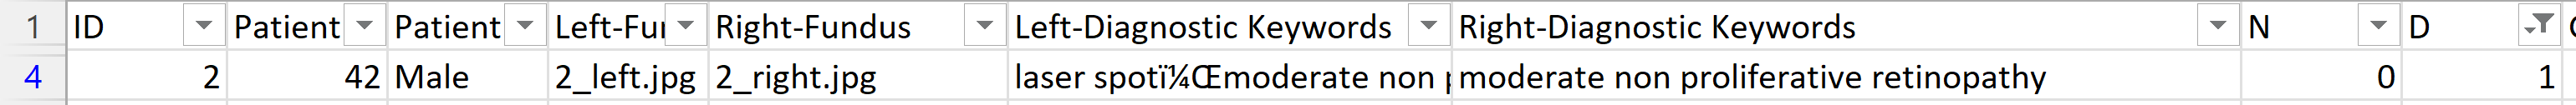